In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal

import gymnasium as gym

import random
import math
import numpy as np
import matplotlib.pyplot as plt


In [248]:
env = gym.make("LunarLander-v2")

In [249]:
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super(PolicyNetwork, self).__init__()
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)
    self.init_layer()
  def forward(self, state):
    x = torch.relu(self.fc1(state))
    x = torch.relu(self.fc2(x))
    action_probs = F.softmax(self.fc3(x), dim=-1)
    return action_probs
  def init_layer(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

In [250]:
def select_action(policy_network, state):
    state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
    dist = policy_network(state)
    action_dist = Categorical(dist)
    action = action_dist.sample()
    action_log_prob = action_dist.log_prob(action)
    return action.item(), action_log_prob.reshape(1)

In [251]:
def describe_episode(episode, loss, episode_reward, step):
    print(f"episode: {episode},loss: {loss}, episode_reward: {episode_reward}, step: {step}")

In [ ]:
gamma = 0.99

result = []
for episode in range(3000):
    state, info = env.reset()
    done = False
    step = 0
    episode_reward = 0
    episode_log_probs = torch.tensor([])
    episode_rewards = []

    while not done:
        step += 1
        # https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
        # Derivation for Basic Policy Gradient
        # Tính log_prob = log_policy( a_t | s_t )
        action, log_prob = select_action(policy_network, state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        episode_rewards.append(reward)
        episode_log_probs =  torch.cat([episode_log_probs, log_prob])
        state = next_state

    # Tính R_i = r_i + gamma * R_{i+1}
    R = [0]
    for i in reversed(episode_rewards):
        G = R[0]
        G = G * gamma + i
        R.insert(0, G)
    R = torch.tensor(R[:-1], dtype=torch.float32)

    # Chuẩn hoá R để giảm phưuong
    R = (R - R.mean()) / (R.std() + 1e-8)

    loss = -1 * torch.sum(episode_log_probs * R)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    describe_episode(episode, loss, episode_reward, step)
    
    result.append(episode_reward)

episode: 0,loss: -57.147491455078125, episode_reward: 258.88759712894716, step: 320
episode: 1,loss: -77.37739562988281, episode_reward: 259.03810859452017, step: 293
episode: 2,loss: 8.42293643951416, episode_reward: 287.67294469397746, step: 228
episode: 3,loss: -100.6038589477539, episode_reward: 243.9364309864808, step: 375
episode: 4,loss: -11.200114250183105, episode_reward: 276.5925803545442, step: 252
episode: 5,loss: 17.326814651489258, episode_reward: 61.14716808068698, step: 217
episode: 6,loss: -20.28879165649414, episode_reward: 283.44660915280804, step: 275
episode: 7,loss: -36.15822982788086, episode_reward: 290.3589720930802, step: 329
episode: 8,loss: -30.279634475708008, episode_reward: 241.87066114304866, step: 298
episode: 9,loss: -24.504329681396484, episode_reward: 311.58435672843814, step: 290
episode: 10,loss: -61.587974548339844, episode_reward: 243.41623953402436, step: 317
episode: 11,loss: -11.247156143188477, episode_reward: 31.62166647785807, step: 180
epi

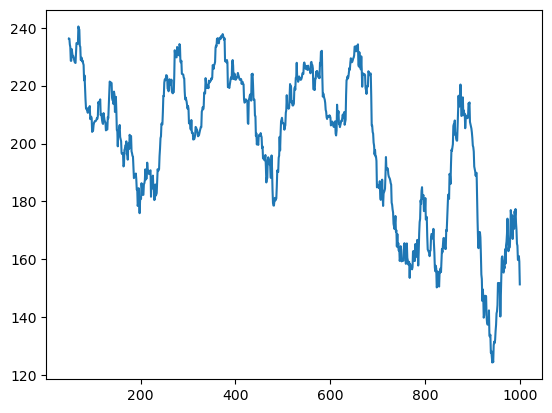

In [267]:
fig, ax = plt.subplots()

import pandas as pd
def smoothen(wind, result):
    result = pd.Series(result)
    result = result.rolling(window=wind).mean()
    return result.values
ax.plot(smoothen(50,result))
plt.show()